In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tabulate

#from sklearn import datasets
#from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.pipeline import make_pipeline

#для расчета ROC-кривой
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

#from sklearn.metrics import accuracy_score #доля правильных ответов в классификации
#from sklearn.metrics import mean_squared_error

**Загрузим датасет и проверим на наличие нулевых значений.**

In [152]:
data=pd.read_csv('C:/Users/Лина/Downloads/Обучение/Машинное обучение/Оценка точности модели, переобучение, регуляризация/ДЗ/adult.csv', delimiter=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


**Выберем первоначальный набор признаков для обучения и целевой столбец.**

In [153]:
selectedColumns = data[['educational-num', 'occupation', 'hours-per-week', 'income']]
selectedColumns['occupation'].value_counts()

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
?                    2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

**Исключим записи, где в значении occupation стоит знак '?', т.к. это значение для обучения равносильно 'non'**

In [154]:
selectedColumns = selectedColumns[~(selectedColumns['occupation']=='?')]
selectedColumns['occupation'].value_counts()

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

**Преобразуем столбец 'occupation' в числовой формат. Создадим тренировочное множество X и исключаем из него целевой столбец 'income'.**

In [155]:
X = pd.get_dummies(selectedColumns, columns=['occupation'])
del X['income']
X.head()

,educational-num,hours-per-week,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving
0,7,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,9,50,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,12,40,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,10,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,6,30,0,0,0,0,0,0,0,1,0,0,0,0,0,0


**Создадим целевое множество и преобразуем целевое поле 'income' в набор 0 и 1.**

In [207]:
le.fit(selectedColumns['income'])
le.classes_
y = pd.Series(data=le.transform(selectedColumns['income']))
y.head()

0    0
1    0
2    1
3    1
4    0
dtype: int32

**Делим выборку на тренировочную и тестовую.**

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
len(X_train) + len(X_test) == len(X)

True

**Создаем модель машинного обучения логической регрессии. Запускаем обучение.**

In [281]:
model = make_pipeline(
StandardScaler(),
LogisticRegression(max_iter=1000))

#обучаем модель
model.fit(X_train,y_train)
predictions = model.predict(X_test)
predictions[:100]
model.predict_proba(X_test)

array([[0.55579147, 0.44420853],
       [0.62110932, 0.37889068],
       [0.50739224, 0.49260776],
       ...,
       [0.86657218, 0.13342782],
       [0.99331788, 0.00668212],
       [0.89758698, 0.10241302]])

**Построим ROC-кривую (Receiver Operating Characteristic).**

In [283]:
# получаем значения false и true positive rate для различных значений порога
fpr, tpr, thres = roc_curve(y_test, predictions)

for line in zip(fpr[:10], tpr[:10], thres[:10]):
    print(line)

(0.0, 0.0, 2)
(0.06499562809676479, 0.3304904051172708, 1)
(1.0, 1.0, 0)


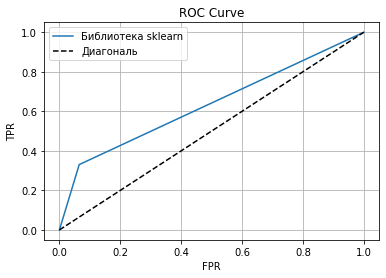

In [349]:
plt.plot(fpr, tpr, label = 'Библиотека sklearn')

# Добавляем диагональ под 45 градусов
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Диагональ')

plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid()

**Выяислим значение ROC-AUC метрики.**

In [285]:
roc_auc_score(y_test, predictions)

0.632747388510253

**Рассчитаем метрики TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.**

In [335]:
predictions = predictions[:100]
y_test = y_test[:100]

tp1 = []
fp1 = []
tn1 = []
fn1 = []

tp = 0
fp = 0
tn = 0
fn = 0

for i in range(20):
    for i in range(len(predictions)):
        if predictions[i] == 1 and y_test[i] == 1:
            tp += 1
    
        elif predictions[i] == 1 and y_test[i] == 0:
            fp += 1
            
        elif predictions[i] == 0 and y_test[i] == 0:
            tn += 1
            
        elif predictions[i] == 0 and y_test[i] == 1:
            fn += 1
            
    tp1.append(tp)
    fp1.append(fp)
    tn1.append(tn)
    fn1.append(fn)

tpr1 = list(map(lambda x: x / len(predictions), tp1))
fpr1 = list(map(lambda x: x / len(predictions), fp1))
    
for line in zip(fpr1, tpr1):
    print(line)

(0.05, 0.07)
(0.1, 0.14)
(0.15, 0.21)
(0.2, 0.28)
(0.25, 0.35)
(0.3, 0.42)
(0.35, 0.49)
(0.4, 0.56)
(0.45, 0.63)
(0.5, 0.7)
(0.55, 0.77)
(0.6, 0.84)
(0.65, 0.91)
(0.7, 0.98)
(0.75, 1.05)
(0.8, 1.12)
(0.85, 1.19)
(0.9, 1.26)
(0.95, 1.33)
(1.0, 1.4)


**Построим ROC-кривую с помощью вычисленных вручную метрик FRP и TRP. Объединим графики метрик FRP и TRP рассчитанных вручную и с помощью библиотеки sklearn.**

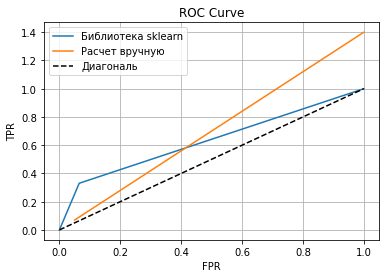

In [347]:
plt.plot(fpr, tpr, label = 'Библиотека sklearn')
plt.plot(fpr1, tpr1, label = 'Расчет вручную')

# Добавляем диагональ под 45 градусов
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Диагональ')

plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid()


**Построим график Precision-Recall, используя показатели TP, FP и FN, рассчитанные вручную.**

In [337]:
pr = list(map(lambda x: x / (len(tp1) + len(fp1)), tp1))
re = list(map(lambda x: x / (len(tp1) + len(fn1)), tp1)) 
print(pr, re)

[0.175, 0.35, 0.525, 0.7, 0.875, 1.05, 1.225, 1.4, 1.575, 1.75, 1.925, 2.1, 2.275, 2.45, 2.625, 2.8, 2.975, 3.15, 3.325, 3.5] [0.175, 0.35, 0.525, 0.7, 0.875, 1.05, 1.225, 1.4, 1.575, 1.75, 1.925, 2.1, 2.275, 2.45, 2.625, 2.8, 2.975, 3.15, 3.325, 3.5]


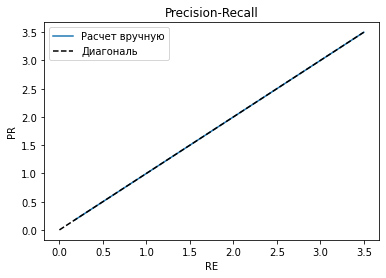

In [351]:
plt.plot(re, pr, label = 'Расчет вручную')

# Добавляем диагональ под 45 градусов
plt.plot([0, 3.5], [0, 3.5], color='black', linestyle='dashed', label='Диагональ')

plt.legend()
plt.xlabel('RE')
plt.ylabel('PR')
plt.title('Precision-Recall')
plt.grid()
plt.grid()

**Вычислим значение ROC-AUC метрики, используя показатели TPR и FPR, рассчитанные вручную.**

In [342]:
auc(fpr1, tpr1)

0.6982499999999999

**Выводы.**

**1 - Как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?**
*Если линия ROC-кривой проходит близко к диагонали, это указывает на низкую эффективность модели. При этом более быстрый подъем кривой вверх указывает на лучшую производительность модели. При переобучении модели, линия ROC-кривой может находиться ниже диагонали.
Так как для нашей модели линия ROC-кривой находится достаточно близко к диагонали, можно сделать вывод, что она не достаточно эффективна (малая точность и специфичность), но вместе с тем не переобучена, так как линия находится не ниже диагонали.*

**2 - Может ли ROC-кривая проходить ниже диагонали?**
*На основании полученных графиков, можно сделать вывод, что ROC-кривая не может проходить ниже диагонали, если она не переобучена.*